Import kaggle untuk mengambil data

In [2]:
!pip install -q kaggle

Masukkan file json yang berisi username dan key

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwinuragustina","key":"fb79c2f12b29a0b535d75a095de795bc"}'}

Downloading private datasets via API

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d shubhammehta21/movie-lens-small-latest-dataset

kaggle.json
  0% 0.00/971k [00:00<?, ?B/s]
100% 971k/971k [00:00<00:00, 66.3MB/s]


Melakukan import library yang digunakan

In [5]:
import os
import zipfile
import numpy as np
import pandas as pd
import nltk
import keras
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from keras import layers
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

Ekstraksi data

In [6]:
local_zip = '/content/movie-lens-small-latest-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()

Membuat dataframe

In [7]:
movie_df = pd.read_csv('/content/movies.csv')
rating_df = pd.read_csv('/content/ratings.csv')
tags_df = pd.read_csv('/content/tags.csv')

Menampilkan informasi data dari file 'movies.csv'

In [8]:
movie_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


Menampilkan detail informasi data dari file 'movies.csv'

In [9]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Memeriksa missing value pada dataset dari file 'movies.csv'

In [10]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

Menghapus kolom yang tidak diperlukan pada file 'ratings.csv'

In [11]:
rating_df = rating_df.drop(['timestamp'], axis = 1)
rating_df

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


Menampilkan informasi dari file 'ratings.csv'

In [12]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


Memeriksa missing value pada dataset dari file 'ratings.csv'

In [13]:
rating_df.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

Menampilkan informasi data dari file 'tags.csv'

In [14]:
tags_df

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200
...,...,...,...,...
3678,606,7382,for katie,1171234019
3679,606,7936,austere,1173392334
3680,610,3265,gun fu,1493843984
3681,610,3265,heroic bloodshed,1493843978


Menampilkan detail informasi dari file 'tags.csv'

In [15]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


Memeriksa missing value pada dataset dari file 'tags.csv'

In [16]:
tags_df.isnull().sum()

userId       0
movieId      0
tag          0
timestamp    0
dtype: int64

Menampilkan informasi data dari file 'ratings.csv'

In [17]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


Menggabungkan dataframe ratings dan movies

In [18]:
new_movie_df = rating_df.merge(movie_df, how = 'inner', on = 'movieId')
new_movie_df.tail()

,userId,movieId,rating,title,genres
100831,610,160341,2.5,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,Blair Witch (2016),Horror|Thriller
100835,610,163981,3.5,31 (2016),Horror


Melakukan normalisasi pada kolom rating

In [19]:
minRating = min(rating_df['rating'])
maxRating = max(rating_df['rating'])
rating_df['rating'] = rating_df["rating"].apply(lambda x : (x - minRating) / (maxRating - minRating)).values.astype(np.float32)
AvgRating = np.mean(rating_df['rating'])

Menampilkan rata-rata rating

In [20]:
print('Rata-rata Rating : ', AvgRating)

Rata-rata Rating :  0.6670127


Memberikan id baru pada setiap baris pada dataframe

In [21]:
# membuat unique value dari userId
userIds = rating_df["userId"].unique().tolist()
encodedUser = {x : i for i,
               x in enumerate(userIds)}

encodedtouser = {i : x for i,
                 x in enumerate(userIds)}

# membuat kolom user dari generate nilai userId
rating_df["user"] = rating_df["userId"].map(encodedUser)
nUsers = len(encodedUser)

# membuat kolom user dari generate movieId
movieIds = rating_df["movieId"].unique().tolist()
firstMovieEncoder = {x : i for i,
                     x in enumerate(movieIds)}

movieEncoder = {i : x for i,
                x in enumerate(movieIds)}

rating_df["movie"] = rating_df["movieId"].map(firstMovieEncoder)
nMovie = len(firstMovieEncoder)

Menampilkan data

In [22]:
rating_df

,userId,movieId,rating,user,movie
0,1,1,0.777778,0,0
1,1,3,0.777778,0,1
2,1,6,0.777778,0,2
3,1,47,1.000000,0,3
4,1,50,1.000000,0,4
...,...,...,...,...,...
100831,610,166534,0.777778,609,3120
100832,610,168248,1.000000,609,2035
100833,610,168250,1.000000,609,3121
100834,610,168252,1.000000,609,1392


Menampilkan data

In [23]:
print("Num of users : {}".format(nUsers))
print("Num of movie : {}".format(nMovie))

print("Min rating : {}".format(min(rating_df['rating'])))
print("Max rating : {}".format(max(rating_df['rating'])))

Num of users : 610
Num of movie : 9724
Min rating : 0.0
Max rating : 1.0


Membagi jumlah data untuk training dan testing

In [24]:
# mengacak sample data
rating_df = rating_df.sample(frac = 1, random_state = 73)

X = rating_df[['user', 'movie']].values
Y = rating_df["rating"]

# membagi data
test_size = 200000
train_indices = rating_df.shape[0] - test_size
X_train, X_test, Y_train, Y_test = (X[:train_indices], X[train_indices:], Y[:train_indices], Y[train_indices:])

# membagi data untuk modelling
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

Embedding layer

In [25]:
def model_preparation():
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding', input_dim = nUsers, output_dim = 128)(user)

    movie = Input(name = 'movie', shape = [1])
    movie_embed = Embedding(name = 'movie_embedding', input_dim = nMovie, output_dim = 128)(movie)
    
    # model menggunakan layer dot
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, movie_embed])
    x = Flatten()(x)
        
    x = Dense(1, kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs = [user, movie], outputs = x)
    model.compile(loss = 'binary_crossentropy', 
                  metrics = ["mse", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
                  optimizer = 'Adam')
    
    return model

Menampilkan model

In [26]:
model = model_preparation()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 movie (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       78080       ['user[0][0]']                   
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 128)       1244672     ['movie[0][0]']                  
                                                                                              

Melakukan training model embedding

In [27]:
best_model = ModelCheckpoint(filepath = './weight.h5',
                             save_weights_only = True,
                             monitor = 'val_loss',
                             mode = 'min',
                             save_best_only = True)

early_stopping = EarlyStopping(patience = 1, 
                               monitor = 'mse', 
                               mode = 'min', 
                               restore_best_weights = True)

my_callbacks = [best_model,
                early_stopping]

Melakukan training model

In [28]:
hist = model.fit(x = X_train_array,
                 y = Y_train,
                 validation_data = (X_test_array, Y_test),
                 epochs = 30,
                 batch_size = 64,
                 verbose = 1,
                 callbacks = my_callbacks)

Epoch 1/30
27/27 [==============================] - 8s 203ms/step - loss: 0.7088 - mse: 0.0865 - precision: 0.9907 - recall: 0.5163 - val_loss: 0.6887 - val_mse: 0.0794 - val_precision: 0.9864 - val_recall: 0.9631
Epoch 2/30
27/27 [==============================] - 6s 228ms/step - loss: 0.6156 - mse: 0.0417 - precision: 1.0000 - recall: 0.5418 - val_loss: 0.6847 - val_mse: 0.0774 - val_precision: 0.9864 - val_recall: 0.9987
Epoch 3/30
27/27 [==============================] - 6s 229ms/step - loss: 0.5868 - mse: 0.0289 - precision: 1.0000 - recall: 0.5654 - val_loss: 0.6810 - val_mse: 0.0755 - val_precision: 0.9864 - val_recall: 0.9997
Epoch 4/30
27/27 [==============================] - 6s 228ms/step - loss: 0.5748 - mse: 0.0239 - precision: 1.0000 - recall: 0.5926 - val_loss: 0.6780 - val_mse: 0.0740 - val_precision: 0.9864 - val_recall: 0.9996
Epoch 5/30
27/27 [==============================] - 2s 94ms/step - loss: 0.5677 - mse: 0.0212 - precision: 1.0000 - recall: 0.5890 - val_loss: 0

Menampilkan plot loss

<function matplotlib.pyplot.show(*args, **kw)>

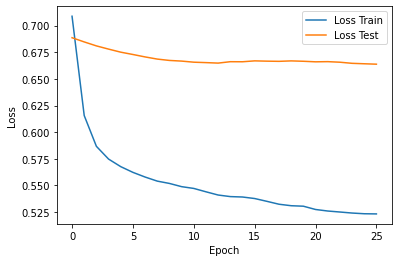

In [29]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Loss Train', 'Loss Test'], loc = 'upper right')
plt.show

Menampilkan plot mse

<function matplotlib.pyplot.show(*args, **kw)>

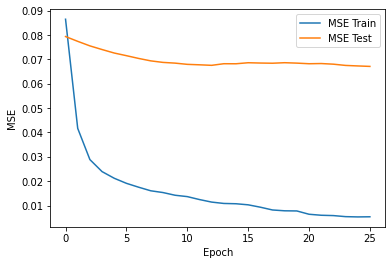

In [30]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['MSE Train', 'MSE Test'], loc = 'upper right')
plt.show

Menampilkan plot recall

<function matplotlib.pyplot.show(*args, **kw)>

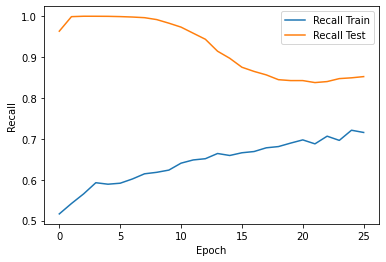

In [31]:
plt.plot(hist.history['recall'])
plt.plot(hist.history['val_recall'])
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Recall Train', 'Recall Test'], loc = 'upper right')
plt.show

Menampilkan plot Precission

<function matplotlib.pyplot.show(*args, **kw)>

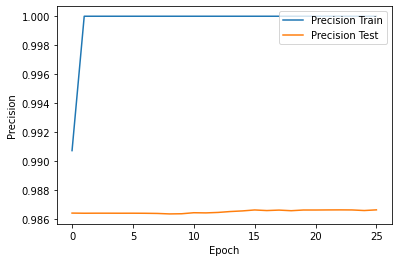

In [32]:
plt.plot(hist.history['precision'])
plt.plot(hist.history['val_precision'])
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Precision Train', 'Precision Test'], loc = 'upper right')
plt.show

Melakukan load weight model

In [33]:
def load_weight(name, model):
    weights = model.get_layer(name).get_weights()[0]
    weights = weights / np.linalg.norm(weights, axis = 1).reshape((-1, 1))
    return weights
    
movie_weights = load_weight('movie_embedding', model)
user_weights = load_weight('user_embedding', model)

Mencari MovieId berdasarkan judul

In [34]:
def movie_data(movie):
    if isinstance(movie, int):
        return movie_df[movie_df.movieId == movie]
    if isinstance(anime, str):
        return movie_df[movie_df.title == movie]

Melakukan collaborative filtering

In [35]:
rating_by_user = rating_df.groupby('userId').size()
random_user = rating_by_user[rating_by_user < 1000].sample(1, random_state = None).index[0]

# memasukkan id user secara random
print('User ID : ', random_user)
top_movie_user = new_movie_df.groupby('userId').get_group(random_user)
top_movie_user[['rating', 'title', 'genres']].sort_values(by = 'rating', ascending = False)

User ID :  562


,rating,title,genres
61257,5.0,Say Anything... (1989),Comedy|Drama|Romance
42981,5.0,"Crazy, Stupid, Love. (2011)",Comedy|Drama|Romance
52613,5.0,Ferris Bueller's Day Off (1986),Comedy
12897,5.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller
75974,5.0,"Cabin in the Woods, The (2012)",Comedy|Horror|Sci-Fi|Thriller
...,...,...,...
13325,3.0,Superman II (1980),Action|Sci-Fi
4102,2.5,Dances with Wolves (1990),Adventure|Drama|Western
39405,2.5,Bewitched (2005),Comedy|Fantasy|Romance
72815,2.5,Shaun of the Dead (2004),Comedy|Horror


Mencari kemiripan user

In [36]:
def get_similar_users(tempId, n = 10):
      index = tempId
      weights = user_weights
      dists = np.dot(weights, weights[encodedUser.get(index)])
      sortedDists = np.argsort(dists)
      n += 1
      closest = sortedDists[-n:]
      print('User that similar to user #{}'.format(tempId))
      
      SimilarArr = []
      
      for close in closest:
          similarity = dists[closest]

          if isinstance(tempId, int):
              SimilarArr.append({"similar_users" : encodeusertouser.get(close), "similarity" : similarity})

      Frame = pd.DataFrame(SimilarArr)
      return Frame

Menampilkan list rekomendasi movie berdasarkan aktivitas tontonan movie user

In [37]:
def get_user_movie_preference(userId, plot = False, temp = 1):
  
  # menentukan batas rating terendah movie
  lowest_rating = np.percentile(rating_df[rating_df.userId == userId].rating, 75)
  rating_df[rating_df.userId == userId] = rating_df[rating_df.userId == userId][rating_df[rating_df.userId == userId].rating >= lowest_rating]
  top_movie_refference = (rating_df[rating_df.userId == userId].sort_values(by = "rating", ascending = False).movieId.values)
  
  user_pref_df = movie_df[movie_df["movieId"].isin(top_movie_refference)]
  user_pref_df = user_pref_df[["movieId","title", "genres"]]
  
  if temp != 0:
      print("User #{} Sudah Menilai {} film dengan peringkat rata-rata = {:.1f}/5.0".format(
        userId, len(rating_df[rating_df.userId==userId]),
        rating_df[rating_df.userId==userId]['rating'].mean()*5,
      ))
      print('Genre film yang direkomendasikan untuk User : ')

  return user_pref_df

Menampilkan 8 rekomendasi movie

In [38]:
reff_user = get_user_movie_preference(random_user, plot = True)
reff_user = pd.DataFrame(reff_user)
reff_user.head(8)

User #562 Sudah Menilai 98 film dengan peringkat rata-rata = 4.7/5.0
Genre film yang direkomendasikan untuk User : 


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
314,356,Forrest Gump (1994),Comedy|Drama|Romance|War
322,364,"Lion King, The (1994)",Adventure|Animation|Children|Drama|Musical|IMAX
461,527,Schindler's List (1993),Drama|War
463,529,Searching for Bobby Fischer (1993),Drama
472,539,Sleepless in Seattle (1993),Comedy|Drama|Romance
